## Identifying Fraudulent Activities
### Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of
money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen
credit cards, doing money laundry, et􀁊.
Machine Learning really excels at identifying fraudulent activities. Any website where you put
your credit card information has a risk team in charge of avoiding frauds via machine learning.
The goal of this challenge is to build a machine learning model that predicts the probability that
the first transaction of a new user is fraudulent.
### Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:
1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it? That is,
what kind of different user experiences would you build based on the model output?

## 1. EDA

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor, BaggingClassifier

In [3]:
sns.__version__

'0.11.1'

In [4]:
fraud_data = pd.read_csv("./Fraud_Data.csv")
Ip_to_country = pd.read_csv("./IpAddress_to_Country.csv")

In [5]:
fraud_data.info("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [6]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
Ip_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
fraud_data[fraud_data.duplicated(keep=False) == True]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class


In [8]:
Ip_to_country[Ip_to_country.duplicated(keep=False) == True]

,lower_bound_ip_address,upper_bound_ip_address,country


In [33]:
country = len(fraud_data) * [0]

for ind, row in fraud_data.iterrows():
    temp = Ip_to_country[(Ip_to_country['lower_bound_ip_address'] < row['ip_address']) & 
           (Ip_to_country['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

fraud_data['country'] = country

In [34]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Overall fraudulent activity rate: 9.36 %


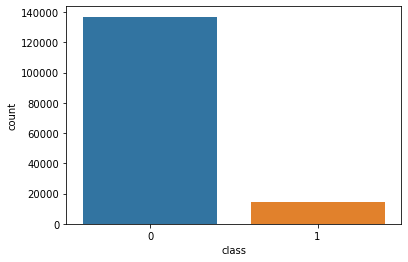

In [35]:
sns.countplot(x='class', data=fraud_data)
print('Overall fraudulent activity rate: %.2f' % (fraud_data[fraud_data['class']==1].shape[0]/fraud_data.shape[0]*100),'%')

In [36]:
fraud_data['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

### This is an imbalanced class dataset, with the fraud class ratio of 9.3%.

In [14]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [15]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [16]:
fraud_data.select_dtypes(include='object').describe()

,signup_time,purchase_time,device_id,source,browser,sex,country
count,151112,151112,151112,151112,151112,151112,151112
unique,151112,150679,137956,3,5,2,182
top,2015-01-22 23:45:41,2015-07-17 23:22:55,ZUSVMDEZRBDTX,SEO,Chrome,M,United States
freq,1,3,20,60615,61432,88293,58049


### There are so many unique values in signup_time and purchase_time and device_id, we will need to apply some process on these features before use them:
1. calculate the time difference between the signup_time and purchase_time, in unit of days or in unit of hours (need to select one); create a new feature as hour of day for purchase time.
2. extract duplicated device/ip frequency as they might be useful features to detect suspicious activities.
3. There are 182 unique countries, we will need to test different encoding methods for it, calculate the fraud rate for each country as a new feature.
4. one-hot encoder for source, browser; binary encoder for sex.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194867D1278>,
      dtype=object)

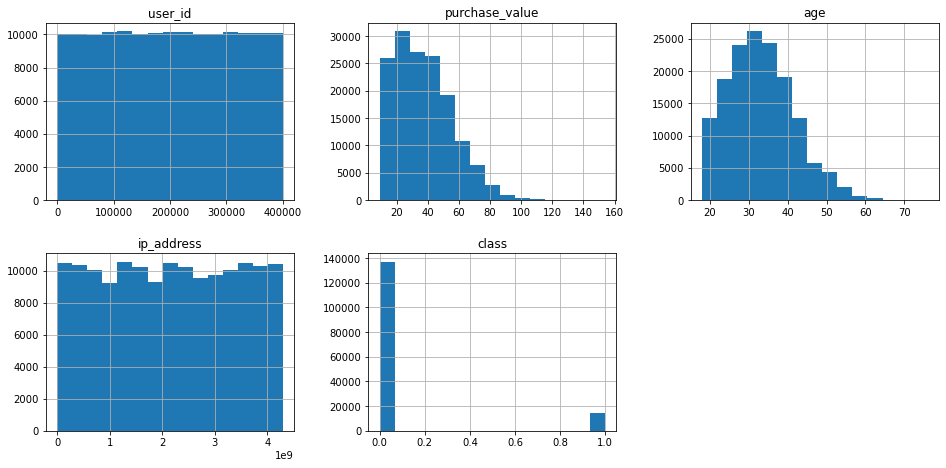

In [17]:
##check the distribution of different features:

fraud_data.hist(bins=15, figsize=(16,16), layout=(4,3))

## 2. Feature engineer and selection

In [37]:
FE_data = fraud_data.copy()

FE_data['signup_time'] = pd.to_datetime(FE_data['signup_time'])
FE_data['purchase_time'] = pd.to_datetime(FE_data['purchase_time'])
FE_data['timedif'] = FE_data['purchase_time'] - FE_data['signup_time']
FE_data['timedif_second'] = FE_data['timedif'].astype('timedelta64[s]')
FE_data['timedif_hour'] = FE_data['timedif'].astype('timedelta64[h]')
FE_data['purchase_hourofday'] = FE_data['purchase_time'].dt.hour
FE_data['purchase_dayofweek'] = FE_data['purchase_time'].dt.dayofweek
FE_data['purchase_month'] = FE_data['purchase_time'].dt.month

In [38]:
FE_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timedif,timedif_second,timedif_hour,purchase_hourofday,purchase_dayofweek,purchase_month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,4506682.0,1251.0,2,5,4
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0 days 04:59:04,17944.0,4.0,1,0,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0 days 00:00:01,1.0,0.0,18,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,5 days 16:41:25,492085.0,136.0,13,0,5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50 days 11:31:01,4361461.0,1211.0,18,2,9


In [39]:
temp = FE_data['device_id'].value_counts().reset_index()
temp.columns = ['device_id', 'device_freq']

temp.head()

,device_id,device_freq
0,EQYVNEGOFLAWK,20
1,ZUSVMDEZRBDTX,20
2,NGQCKIADMZORL,20
3,KIPFSCNUGOLDP,20
4,ITUMJCKWEYNDD,20


b:\program files\phthon\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


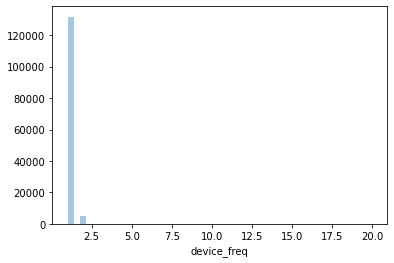

In [17]:
sns.distplot(temp.device_freq, kde=False)

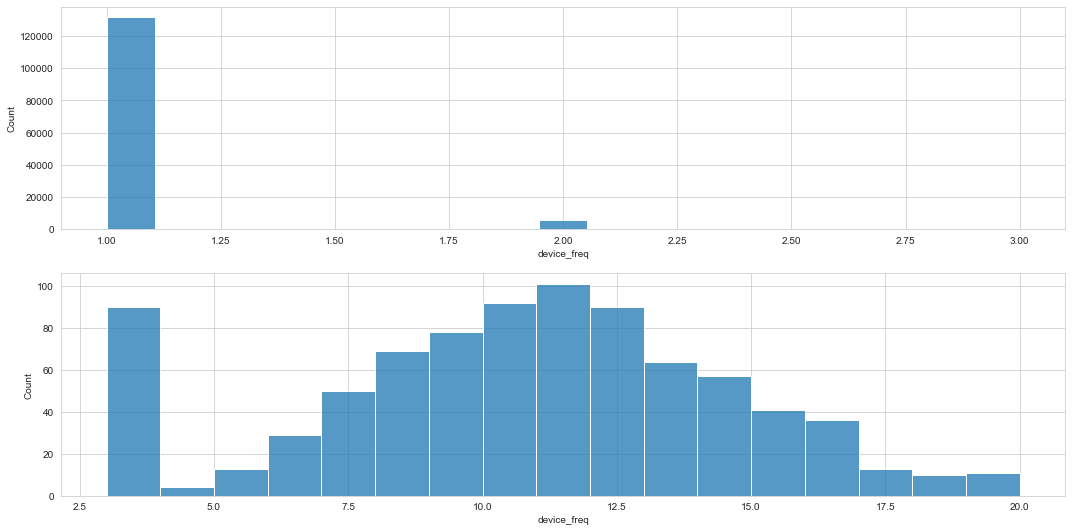

In [31]:
plt.figure(figsize=(18,9))
sns.set_style("whitegrid")
plt.subplot(2,1,1)
sns.histplot(temp.device_freq[temp.device_freq < 4])
plt.subplot(2,1,2)
sns.histplot(temp.device_freq[temp.device_freq > 2])

In [40]:
temp2 = FE_data['ip_address'].value_counts().reset_index()
temp2.columns = ['ip_address', 'ip_freq']

temp2['ip_freq'].value_counts()

1     142752
11       100
12        91
10        89
9         82
8         71
13        64
14        59
7         50
16        36
15        36
6         30
5         13
17        12
18         9
19         7
4          4
20         4
3          2
2          1
Name: ip_freq, dtype: int64

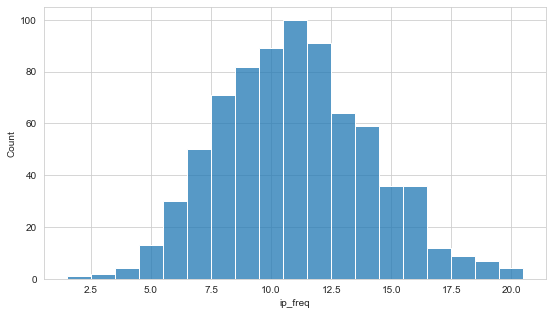

In [30]:
plt.figure(figsize=(9,5))
sns.set_style("whitegrid")
sns.histplot(temp2.ip_freq[temp2.ip_freq > 1], discrete=True)


In [41]:
temp3 = FE_data['user_id'].value_counts().reset_index()
temp3.columns = ['user_id', 'id_freq']

temp3['id_freq'].value_counts()

1    151112
Name: id_freq, dtype: int64

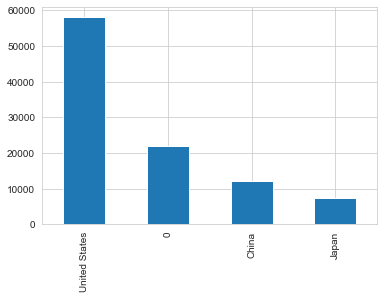

In [44]:
#Let's see the rank of countries with more than 5000 records:
FE_data.country.value_counts()[FE_data.country.value_counts() >5000].plot(kind="bar")

In [56]:
print(FE_data[(FE_data['country'] == 'India') & (FE_data['class'] == 1)].shape[0], FE_data[FE_data['country'] == 'India'].shape[0])

151 1310


In [42]:
temp4 = []
for each in FE_data['country'].unique():
    fd_ratio = FE_data[(FE_data['country'] == each) & (FE_data['class'] == 1)].shape[0]/FE_data[FE_data['country'] == each].shape[0]
    count = FE_data[FE_data['country'] == each].shape[0]
    print(each, fd_ratio, count)
    temp4.append([each, fd_ratio, count])

Japan 0.09786476868327403 7306
United States 0.09562610897689883 58049
0 0.08572339069471001 21966
Canada 0.11697478991596638 2975
China 0.08664229938527995 12038
Brazil 0.0911854103343465 2961
India 0.11526717557251909 1310
Argentina 0.09984871406959153 661
United Kingdom 0.10623608017817372 4490
South Africa 0.0883054892601432 838
Germany 0.0718595721338453 3646
Mexico 0.12845673505798394 1121
Sweden 0.12018348623853212 1090
Korea Republic of 0.0913022585295531 4162
Peru 0.2605042016806723 119
Portugal 0.043668122270742356 229
Bangladesh 0.08108108108108109 37
France 0.09490667510281557 3161
Taiwan; Republic of China (ROC) 0.08003233629749394 1237
Russian Federation 0.08292079207920793 1616
Belgium 0.13691931540342298 409
Denmark 0.15918367346938775 490
Netherlands 0.07321428571428572 1680
Iran (ISLAMIC Republic Of) 0.10796915167095116 389
Spain 0.07108081791626096 1027
Gabon 0.0 9
Saudi Arabia 0.1893939393939394 264
Hong Kong 0.12951167728237792 471
Georgia 0.0625 32
Syrian Arab Rep

In [43]:
temp4df = pd.DataFrame(data=temp4, columns = ['country', 'fraud_ratio', 'count'])
temp4df.sort_values(by=['fraud_ratio'], ascending=False)

,country,fraud_ratio,count
92,Turkmenistan,1.000000,1
81,Namibia,0.434783,23
119,Sri Lanka,0.419355,31
114,Luxembourg,0.388889,72
127,Virgin Islands (U.S.),0.333333,3
...,...,...,...
130,Uganda,0.000000,13
128,Congo,0.000000,3
126,South Sudan,0.000000,1
124,Bahrain,0.000000,14


### The fraud ratio per country has selection bias, so we cannot use it directly, we can consider to bin them into different categories.

In [22]:
temp4df["risk_country"] = temp4df["fraud_ratio"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")

In [25]:
FE2_data = pd.merge(FE_data, temp, how='outer', on='device_id')
FE2_data = pd.merge(FE2_data, temp2, how='outer', on='ip_address')
FE2_data = pd.merge(FE2_data, temp4df, how='outer', on='country')
FE2_data.head()

KeyError: 'country'

In [84]:
#apply binning to age, hourofday
FE2_data['age_bin'] = FE2_data['age'].apply(lambda x: 
                                             "< 20" if x < 20 else
                                             "20 - 29" if x < 30 else
                                             "30 -39" if x < 40 else
                                             "40 - 49" if x < 50 else
                                             "50 - 59" if x < 60 else
                                             " > 60")

FE2_data["period_of_the_day"] = FE2_data['purchase_hourofday'].apply(lambda x : 
                                                             "midnight" if x < 2 else
                                                             "early morning" if x < 5 else
                                                             "morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "afternoon " if x < 18 else
                                                             "evening" if x < 22 else
                                                             "late night"
                                                            )

FE2_data["quick_purchase"] = FE2_data['timedif_second'].apply(lambda x : 1 if x < 30 else 0)


In [85]:
FE2_data['country'].replace(to_replace = 0, value = 'others', inplace=True)

In [26]:
dummy_source = pd.get_dummies(FE2_data, prefix=['source'], columns=['source'], drop_first=True)
dummy_source = pd.get_dummies(dummy_source, prefix=['browser'], columns=['browser'], drop_first=True)

le = LabelEncoder()
dummy_source['sex'] = le.fit_transform(FE2_data['sex'])

In [87]:
dummy_source

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,country,...,risk_country,age_bin,period_of_the_day,quick_purchase,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,1,39,7.327584e+08,0,Japan,...,High risk,30 -39,early morning,0,0,1,0,0,0,0
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,0,32,2.521871e+09,0,Japan,...,High risk,30 -39,afternoon,0,1,0,0,0,0,0
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,0,44,3.682312e+09,0,Japan,...,High risk,40 - 49,morning,0,1,0,0,0,0,0
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,0,49,3.665105e+09,0,Japan,...,High risk,40 - 49,afternoon,0,1,0,0,1,0,0
4,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,0,34,7.359961e+08,0,Japan,...,High risk,30 -39,morning,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,0,23,3.277722e+09,0,Yemen,...,Low risk,20 - 29,early morning,0,0,1,0,1,0,0
151108,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,1,34,1.505370e+09,0,San Marino,...,Low risk,30 -39,early morning,0,0,0,0,0,0,0
151109,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,0,24,3.314912e+09,0,Burundi,...,Low risk,20 - 29,morning,0,0,0,1,0,0,0
151110,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,1,30,3.412259e+09,0,Nauru,...,Low risk,30 -39,evening,0,0,1,1,0,0,0


In [94]:
FE3_data = dummy_source.drop(['signup_time', 'purchase_time', 'country', 'fraud_ratio', 'count', 'device_id', 'timedif', 'timedif_second', 'ip_address'], axis=1)
FE3_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             151112 non-null  int64  
 1   purchase_value      151112 non-null  int64  
 2   sex                 151112 non-null  int32  
 3   age                 151112 non-null  int64  
 4   class               151112 non-null  int64  
 5   timedif_hour        151112 non-null  float64
 6   purchase_hourofday  151112 non-null  int64  
 7   purchase_dayofweek  151112 non-null  int64  
 8   purchase_month      151112 non-null  int64  
 9   device_freq         151112 non-null  int64  
 10  ip_freq             151112 non-null  int64  
 11  risk_country        151112 non-null  object 
 12  age_bin             151112 non-null  object 
 13  period_of_the_day   151112 non-null  object 
 14  quick_purchase      151112 non-null  int64  
 15  source_Direct       151112 non-nul

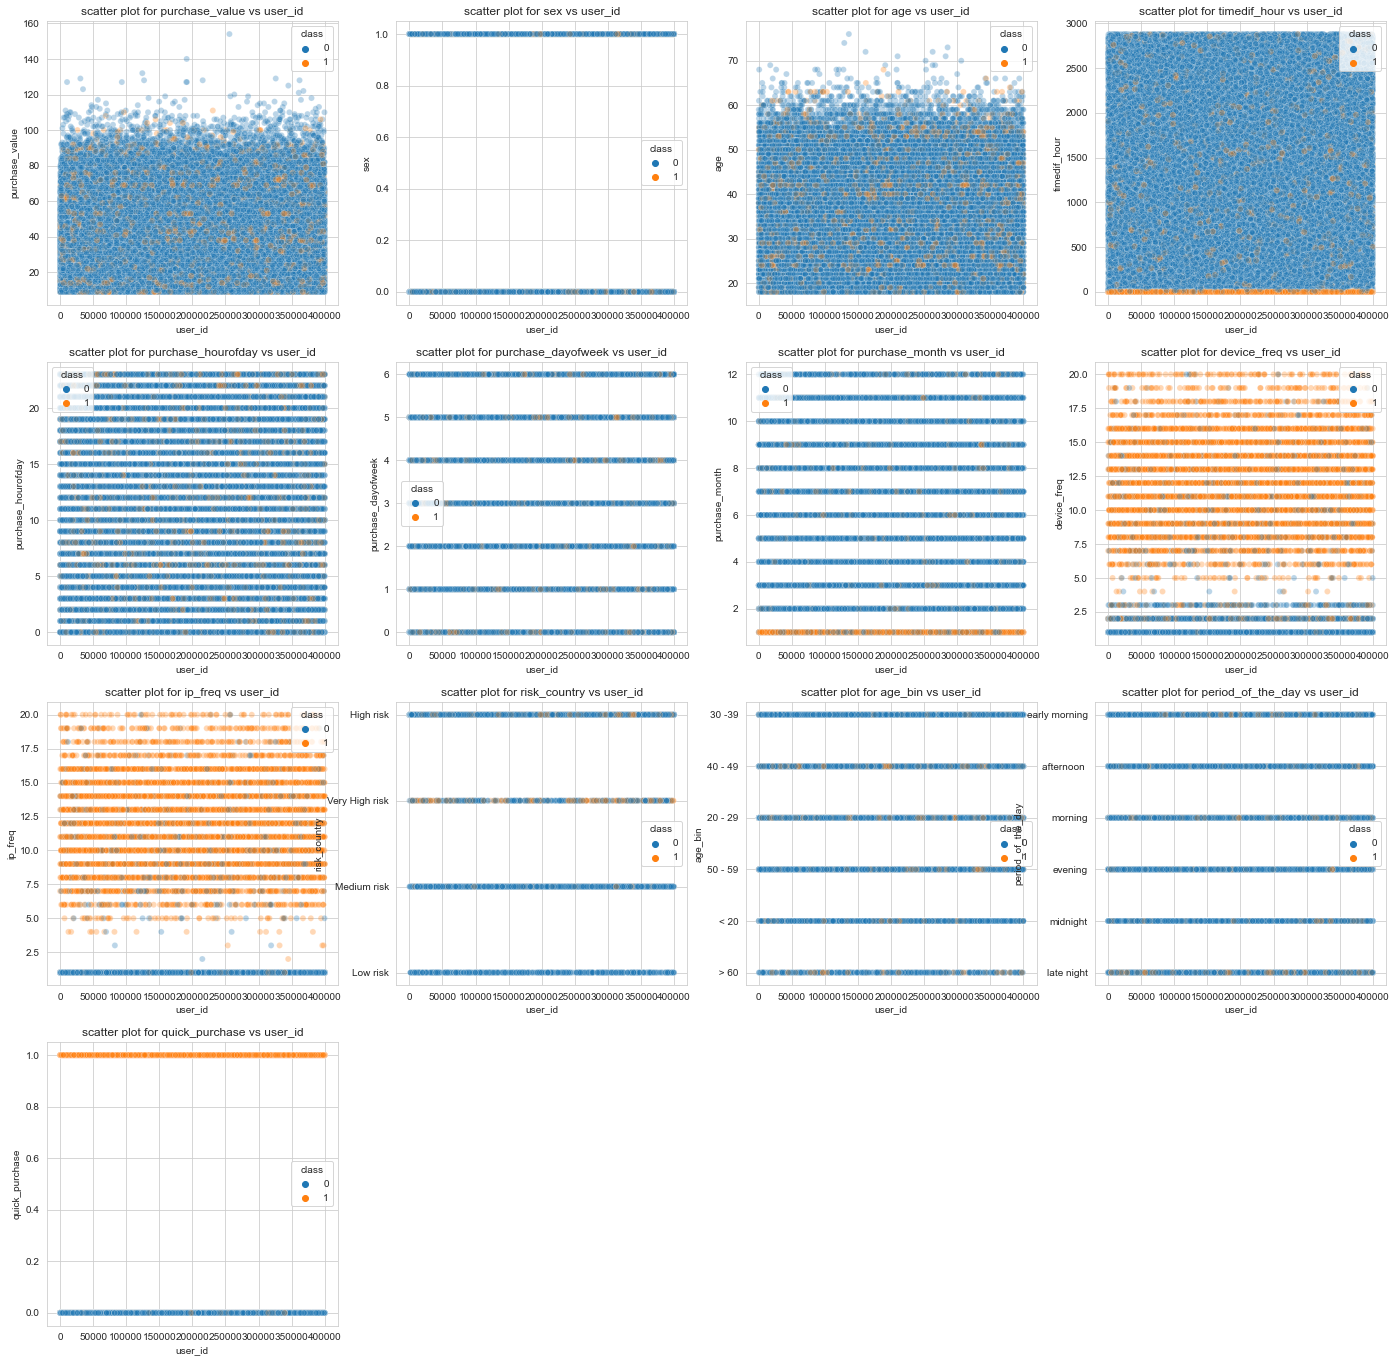

In [95]:
allmetrics = FE3_data.drop(['class', 'user_id'],axis=1)
allmetrics = allmetrics.select_dtypes(exclude='uint8').columns
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,4,n)
    sns.scatterplot(x='user_id', y=each, hue='class', data=FE3_data, alpha=0.3)
    plt.title('scatter plot for {} vs user_id'.format(each))
    n += 1

In [99]:
le = LabelEncoder()
FE3_data['risk_country'] = le.fit_transform(FE3_data['risk_country'])
FE3_data['age_bin'] = le.fit_transform(FE3_data['age_bin'])
FE3_data['period_of_the_day'] = le.fit_transform(FE3_data['period_of_the_day'])


### From this scatter plot, it's obvious to spot the correlation between the device_frequency and the fraudulent activities.

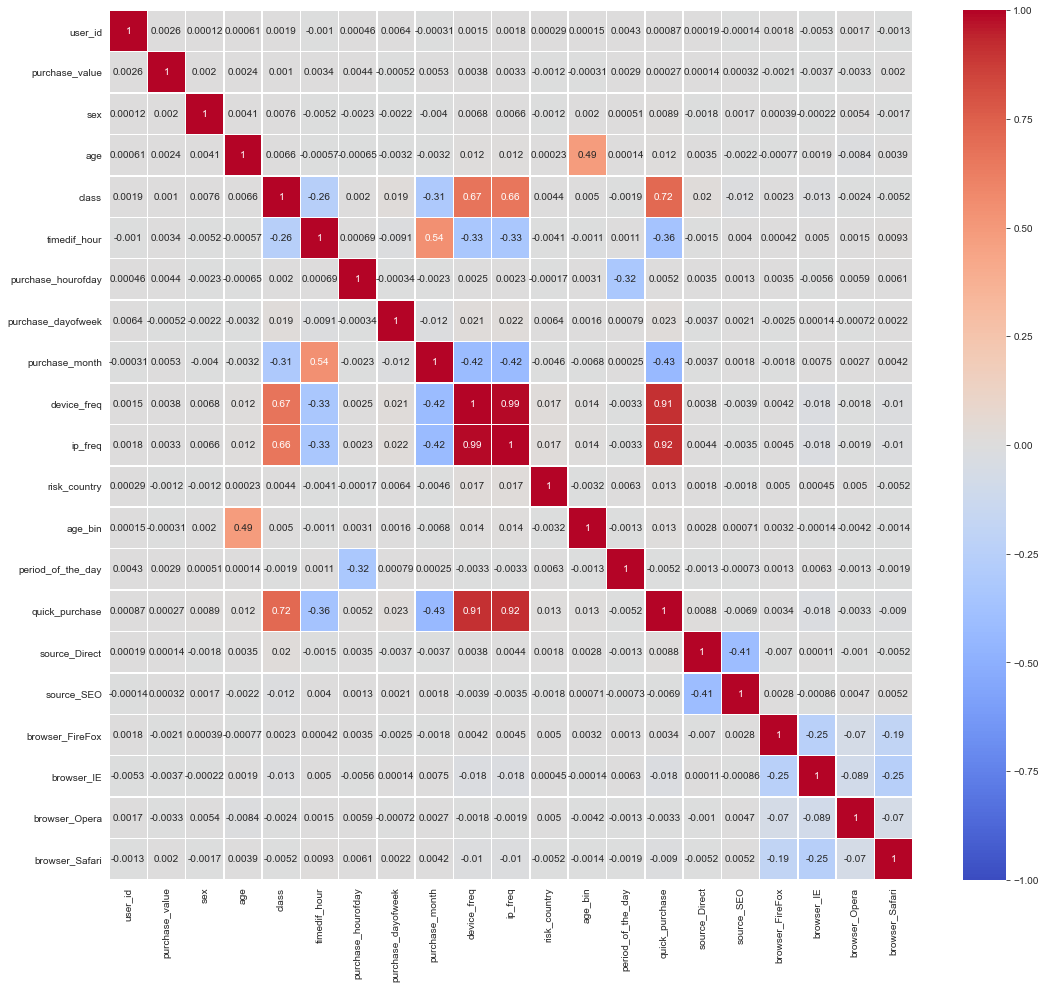

In [100]:
#What's the correlation between these variables?
corr = FE3_data.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corr, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

### The heat map is also showing similar conclusion that the device_freq is closely correlated to the class, the timediff_hour also seem to be related.

In [49]:
##train test data split with stratified splitting
FE_X = FE2_data.drop(['class'], axis=1)
FE_y = FE2_data['class']

X_train, X_test, y_train, y_test = train_test_split(FE_X, FE_y, train_size=0.8, random_state=42, stratify=FE_y)


In [28]:
y_train.value_counts()

0    109568
1     11321
Name: class, dtype: int64

In [116]:
##test resampling by SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

y_train_smt.value_counts()


1    109568
0    109568
Name: class, dtype: int64

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120889 entries, 55802 to 122175
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   user_id             120889 non-null  int64          
 1   signup_time         120889 non-null  datetime64[ns] 
 2   purchase_time       120889 non-null  datetime64[ns] 
 3   purchase_value      120889 non-null  int64          
 4   device_id           120889 non-null  object         
 5   source              120889 non-null  object         
 6   browser             120889 non-null  object         
 7   sex                 120889 non-null  object         
 8   age                 120889 non-null  int64          
 9   ip_address          120889 non-null  float64        
 10  timedif             120889 non-null  timedelta64[ns]
 11  timedif_second      120889 non-null  float64        
 12  timedif_hour        120889 non-null  float64        
 13  purchase_h

## Modeling

In [47]:
##baseline model with logistic regression.

lr = linear_model.LogisticRegression(random_state=42)
lr_clf = lr.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(lr_clf, X_train, y_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

TypeError: invalid type promotion

In [30]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(lr_clf, X_train, y_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

TypeError: invalid type promotion

In [104]:
y_pred = lr_clf.predict(X_test)
print('The confusion matrix for logistic regression is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred, labels=[1, 0], digits=4))

The confusion matrix for logistic regression is:
 [[ 1983   847]
 [ 9395 17998]]
              precision    recall  f1-score   support

           1     0.1743    0.7007    0.2791      2830
           0     0.9551    0.6570    0.7785     27393

    accuracy                         0.6611     30223
   macro avg     0.5647    0.6789    0.5288     30223
weighted avg     0.8819    0.6611    0.7317     30223



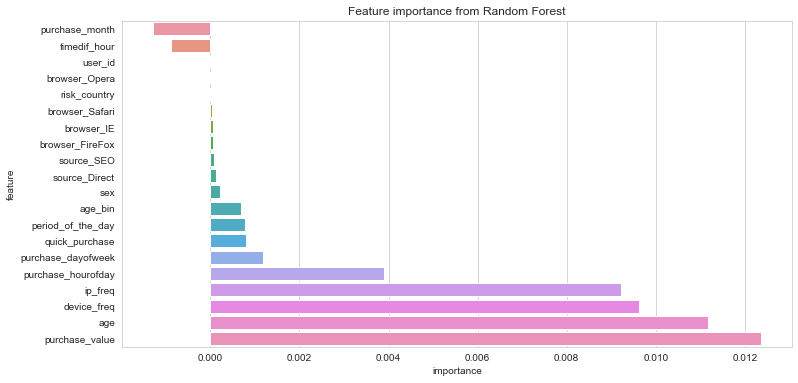

In [105]:
#print the feature importance
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = lr_clf.coef_[0]
features.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features['importance'], y=features['feature'], order=features.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

In [106]:
##random forest 

rfclf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf = rfclf.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(rfclf, X_train, y_train, scoring='f1', cv=5)
print('random forest cv avg score:', cv_score.mean())

random forest cv avg score: 0.701466058472657


In [107]:
y_pred2 = rfclf.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred2, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred2, labels=[1, 0], digits=4))

The confusion matrix for random forest is:
 [[ 1484  1346]
 [   46 27347]]
              precision    recall  f1-score   support

           1     0.9699    0.5244    0.6807      2830
           0     0.9531    0.9983    0.9752     27393

    accuracy                         0.9539     30223
   macro avg     0.9615    0.7614    0.8280     30223
weighted avg     0.9547    0.9539    0.9476     30223



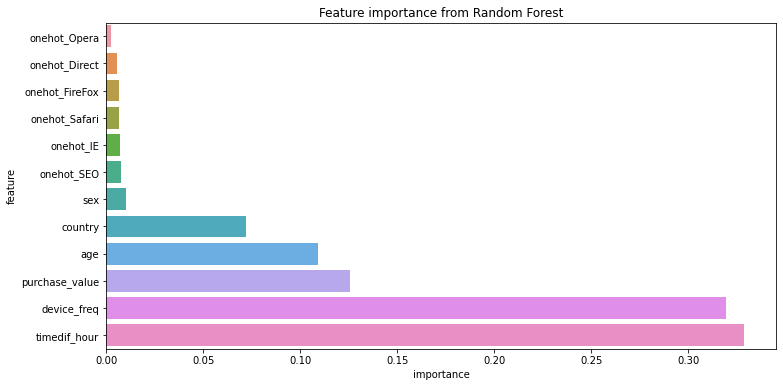

In [108]:
#print the feature importance
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = rfclf.feature_importances_
features.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features['importance'], y=features['feature'], order=features.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

In [121]:
##random forest with SMOTE input

rfclf2 = RandomForestClassifier(random_state=42)

rf2 = rfclf2.fit(X_train_smt, y_train_smt)
cv_score = model_selection.cross_val_score(rfclf2, X_train_smt, y_train_smt, scoring='f1', cv=5)
print('random forest cv avg score:', cv_score.mean())

y_pred22 = rfclf2.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred22, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred22, labels=[1, 0], digits=4))

random forest cv avg score: 0.9128688036240089
The confusion matrix for random forest is:
 [[ 1633  1197]
 [ 1932 25461]]
              precision    recall  f1-score   support

           1     0.4581    0.5770    0.5107      2830
           0     0.9551    0.9295    0.9421     27393

    accuracy                         0.8965     30223
   macro avg     0.7066    0.7533    0.7264     30223
weighted avg     0.9086    0.8965    0.9017     30223



## SMOTE seems boost the recall while reduce the precision.

In [119]:
##random forest with SMOTE input

rfclf2 = RandomForestClassifier(random_state=42, class_weight='balanced')

steps = [('smote',smt),('clf', rfclf2)]
pipeline = Pipeline(steps=steps)

rf2 = pipeline.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=5)
print('random forest cv avg score:', cv_score.mean())

y_pred22 = pipeline.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred22, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred22, labels=[1, 0], digits=4))

random forest cv avg score: 0.5243248810124249
The confusion matrix for random forest is:
 [[ 1633  1197]
 [ 1932 25461]]
              precision    recall  f1-score   support

           1     0.4581    0.5770    0.5107      2830
           0     0.9551    0.9295    0.9421     27393

    accuracy                         0.8965     30223
   macro avg     0.7066    0.7533    0.7264     30223
weighted avg     0.9086    0.8965    0.9017     30223



In [130]:
from imblearn.under_sampling import RandomUnderSampler


def our_opt(smt, rus, X_test, y_test):
    smt2 = SMOTE(sampling_strategy=smt/10, random_state=42)
    rus2 = RandomUnderSampler(sampling_strategy=rus/10, random_state=42)
    rf2our = RandomForestClassifier(random_state=42)
    
    steps = [('o', smt2), ('u', rus2), ('rfclf', rf2our)]
    pipeline = Pipeline(steps=steps)
    
    rf2our_clf = pipeline.fit(X_train, y_train)
    
    y_predourv = pipeline.predict(X_test)
    f1_scores = f1_score(y_test, y_predourv)
    print('for smt {} and rus {}, f1 score is {}'.format(smt/10, rus/10, f1_scores))
    return f1_scores

table2 = {}
max = 0
for i in range(2,10,1):
    for j in range(i,10,1):
        f1 = our_opt(i, j, X_test, y_test)
        table2[f1] = (i/10, j/10)
        if f1 > max:
            max = f1
print(max, table2[max])

for smt 0.2 and rus 0.2, f1 score is 0.6621414495292315
for smt 0.2 and rus 0.3, f1 score is 0.6458888661062129
for smt 0.2 and rus 0.4, f1 score is 0.6271026271026271
for smt 0.2 and rus 0.5, f1 score is 0.6025017373175816
for smt 0.2 and rus 0.6, f1 score is 0.5760590500641848
for smt 0.2 and rus 0.7, f1 score is 0.5550224887556222
for smt 0.2 and rus 0.8, f1 score is 0.5308833922261484
for smt 0.2 and rus 0.9, f1 score is 0.5124431362055124
for smt 0.3 and rus 0.3, f1 score is 0.6284536082474226
for smt 0.3 and rus 0.4, f1 score is 0.6103771778671261
for smt 0.3 and rus 0.5, f1 score is 0.5881513204853676
for smt 0.3 and rus 0.6, f1 score is 0.5656399275242958
for smt 0.3 and rus 0.7, f1 score is 0.5422776911076443
for smt 0.3 and rus 0.8, f1 score is 0.5243369280093267
for smt 0.3 and rus 0.9, f1 score is 0.5114926613126558
for smt 0.4 and rus 0.4, f1 score is 0.6094269509094464
for smt 0.4 and rus 0.5, f1 score is 0.5844464775846294
for smt 0.4 and rus 0.6, f1 score is 0.567641996

KeyboardInterrupt: 

In [135]:
##random forest using roc_auc to evaluate

rfclf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf = rfclf.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(rfclf, X_train, y_train, scoring='roc_auc', cv=5)
print('random forest cv avg score:', cv_score.mean())

random forest cv avg score: 0.8401784695130367


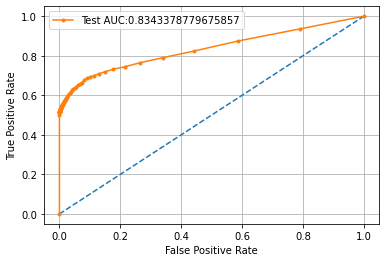

AUC for the model is: 0.8343378779675857


In [136]:
y_scores = rfclf.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

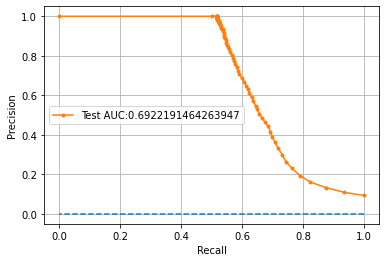

AUC for the model is: 0.6922191464263947


In [141]:
y_scores = rfclf.predict_proba(X_test)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

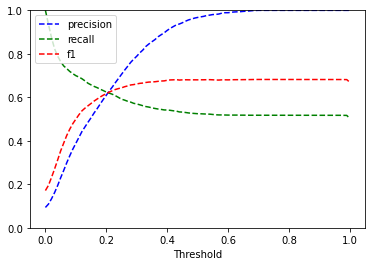

In [142]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()